In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import shapiro, kstest
import os


In [280]:
# Image directory path
output_dir = "./img/"

# 1. Load Data

In [9]:
# Load dex volumes for each ERC-20 token
usdt_df = pd.read_csv("data/on-chain/usdt_dex_volumes_2024.csv", parse_dates=["day"], index_col="day")
usdc_df = pd.read_csv("data/on-chain/usdc_dex_volumes_2024.csv", parse_dates=["day"], index_col="day")
uni_df = pd.read_csv("data/on-chain/uni_dex_volumes_2024.csv", parse_dates=["day"], index_col="day")
pol_df = pd.read_csv("data/on-chain/pol_dex_volumes_2024.csv", parse_dates=["day"], index_col="day")

# Display an overview of all datasets
datasets = {"USDT": usdt_df, "USDC": usdc_df, "UNI": uni_df, "POL": pol_df}
for token, df in datasets.items():
    print(f"{token} DataFrame:")
    print(df.info(), "\n")

USDT DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7063 entries, 2024-01-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   daily_volume_usd  7063 non-null   float64
 1   project           7063 non-null   object 
 2   trade_count       7063 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 220.7+ KB
None 

USDC DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7659 entries, 2024-01-01 to 2024-12-31
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   daily_volume_usd  7659 non-null   float64
 1   project           7659 non-null   object 
 2   trade_count       7659 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 239.3+ KB
None 

UNI DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3228 entries, 2024-01-01 to 2024-12-31
D

# 2. Visualization

### 2.1 Total Transaction Volumes Chart (Aggregated Projects)

In [281]:
def plot_total_volume_bar_with_colors(datasets):
    """
    Plot the time series of total transaction volumes (aggregated projects) for each token as bar charts.

    Args:
        datasets (dict): Dictionary where keys are token names and values are their DataFrames.
    """
    num_tokens = len(datasets)
    colors = cm.tab10(np.linspace(0, 1, num_tokens)) 
    fig, axes = plt.subplots(num_tokens, 1, figsize=(12, 4 * num_tokens), sharex=True)
    fig.suptitle("Total Transaction Volumes Over Time (Aggregated Projects)", fontsize=16)

    for ax, (token, df), color in zip(axes, datasets.items(), colors):
        # Aggregate transaction volumes by day
        aggregated_df = df.groupby(df.index)['daily_volume_usd'].sum()

        ax.bar(aggregated_df.index, aggregated_df, label="Total Volume", color=color, width=1)
        ax.set_title(f"{token}")
        ax.set_ylabel("Volume (USD)")
        ax.grid(True, axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
        ax.legend()

    plt.xlabel("Date")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    output_path = os.path.join(output_dir, "total_txn_vol_all_tokens_2024.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


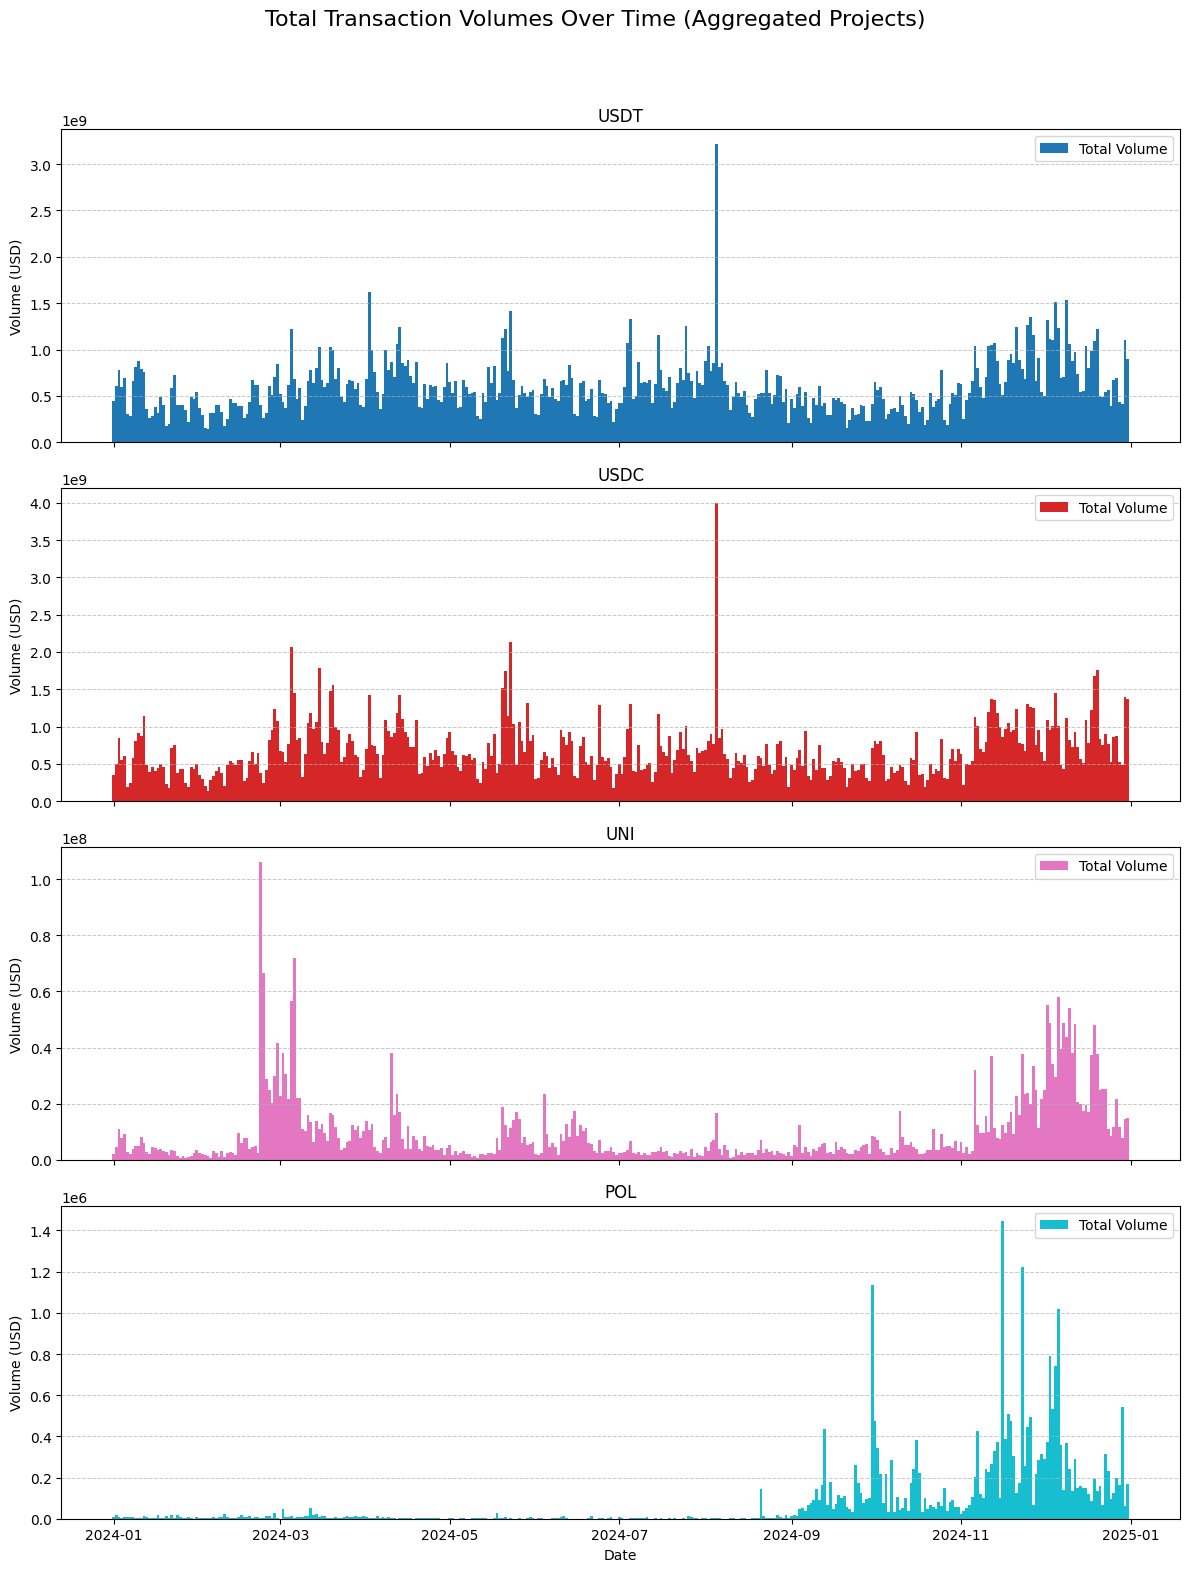

In [284]:
plot_total_volume_bar_with_colors(datasets)

### 2.2 Market Share Comparison By Project (DEX)

In [285]:
def plot_market_shares(datasets, threshold=0.05):
    """
    Plots pie charts showing the market share by project for multiple tokens.

    Args:
        datasets (dict): Dictionary where keys are token names and values are their DataFrames.
        threshold (float): Percentage threshold for grouping smaller projects into "Other".
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, len(datasets), figsize=(18, 6))
    fig.suptitle("Market Share by Project for Each Token", fontsize=16)

    # Loop through the datasets and plot pie charts
    for ax, (token, df) in zip(axes, datasets.items()):
        # Aggregate total transaction volume by project
        project_volumes = df.groupby('project')['daily_volume_usd'].sum()

        # Calculate percentage share
        total_volume = project_volumes.sum()
        project_volumes_percent = project_volumes / total_volume

        # Group smaller projects into "Other"
        large_projects = project_volumes_percent[project_volumes_percent >= threshold]
        small_projects = project_volumes_percent[project_volumes_percent < threshold]
        large_projects['Other'] = small_projects.sum()

        # Create the pie chart
        ax.pie(
            large_projects.values,
            labels=large_projects.index,
            autopct='%1.1f%%',
            startangle=140
        )
        ax.set_title(f"{token}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
    output_path = os.path.join(output_dir, "market_share_by_project.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


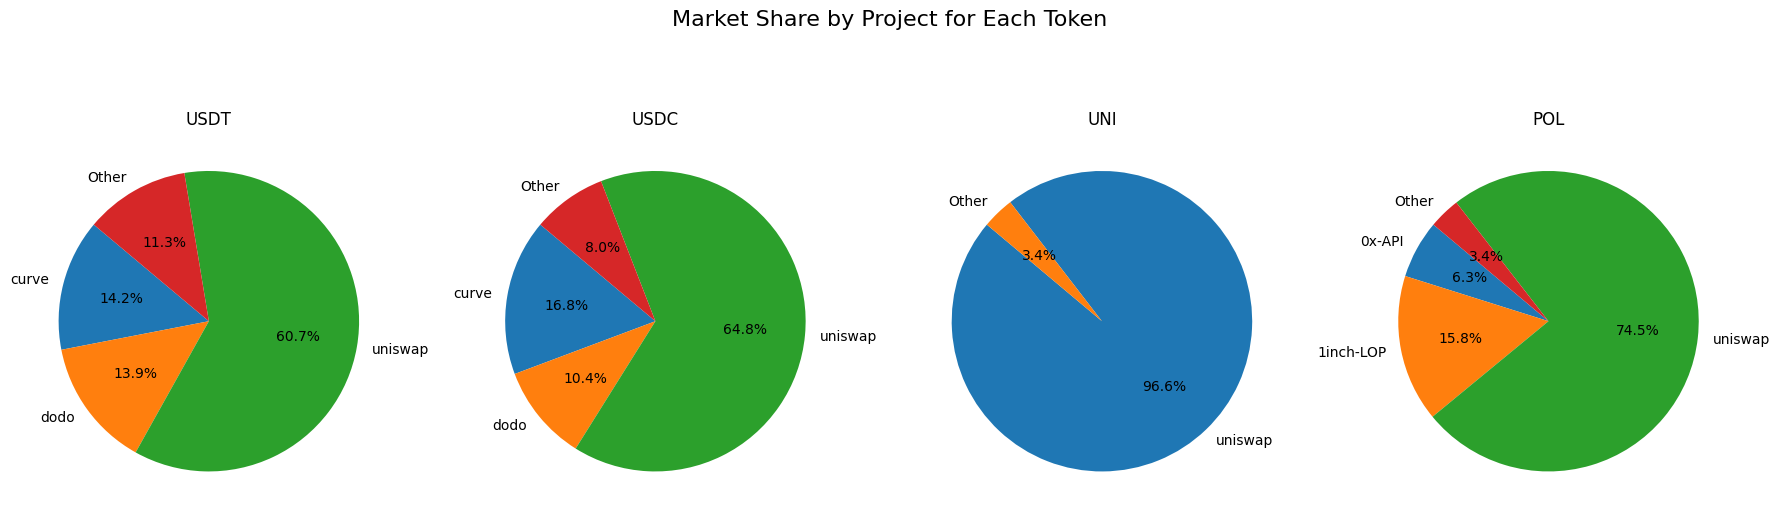

In [286]:
plot_market_shares(datasets, threshold=0.05)

# 3. Time Series Analysis

### 3.1 Aggregate Transaction Volumes into DataFrame

In [293]:
aggregated_volumes = {
    f"{token.lower()}_txn_vol": df.groupby(df.index)['daily_volume_usd'].sum()
    for token, df in datasets.items()
}

volume_df = pd.DataFrame(aggregated_volumes)
volume_df.head()

,usdt_txn_vol,usdc_txn_vol,uni_txn_vol,pol_txn_vol
day,,,,
2024-01-01,4.399841e+08,3.465440e+08,2.080106e+06,9133.163600
2024-01-02,6.096289e+08,4.923949e+08,4.545773e+06,17350.152758
2024-01-03,7.787145e+08,8.448689e+08,1.092697e+07,8669.707669
2024-01-04,5.993897e+08,5.542500e+08,7.720551e+06,5396.324524
2024-01-05,6.925086e+08,6.070909e+08,9.085949e+06,6191.367193


### 3.2 Calculate Transaction Volume Log Changes

In [294]:
volume_df.fillna(method='ffill', inplace=True)  # Forward fill missing values in pol_txn_vol
volume_changes_df = np.log(volume_df / volume_df.shift(1))
volume_changes_df.dropna(inplace=True)
volume_changes_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-02 to 2024-12-31
Freq: D
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   usdt_txn_vol  365 non-null    float64
 1   usdc_txn_vol  365 non-null    float64
 2   uni_txn_vol   365 non-null    float64
 3   pol_txn_vol   365 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB


/var/folders/mf/b1lhfbsd0_v8415y834bgj_c0000gn/T/ipykernel_24053/1416357948.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volume_df.fillna(method='ffill', inplace=True)  # Forward fill missing values in pol_txn_vol


### 3.3 Descriptive Statistics of Changes

In [295]:
def calculate_descriptive_statistics(dataframe):
    """
    Calculate and display descriptive statistics for log changes in daily transaction volumes of all tokens.

    Args:
        dataframe (pd.DataFrame): DataFrame containing log changes for all tokens.
    """
    descriptive_stats = {}

    for token in dataframe.columns:
        stats = dataframe[token].describe()
        descriptive_stats[token] = stats

        print(f"Descriptive Statistics for {token}:\n{stats}\n{'-' * 50}")

    return descriptive_stats

stats = calculate_descriptive_statistics(volume_changes_df)


Descriptive Statistics for usdt_txn_vol:
count    365.000000
mean       0.001962
std        0.407151
min       -1.372686
25%       -0.233003
50%       -0.007100
75%        0.244794
max        1.329313
Name: usdt_txn_vol, dtype: float64
--------------------------------------------------
Descriptive Statistics for usdc_txn_vol:
count    365.000000
mean       0.003753
std        0.467549
min       -1.545530
25%       -0.255675
50%       -0.011232
75%        0.259676
max        1.655127
Name: usdc_txn_vol, dtype: float64
--------------------------------------------------
Descriptive Statistics for uni_txn_vol:
count    365.000000
mean       0.005390
std        0.663539
min       -1.644487
25%       -0.414118
50%       -0.053666
75%        0.365504
max        3.811818
Name: uni_txn_vol, dtype: float64
--------------------------------------------------
Descriptive Statistics for pol_txn_vol:
count    365.000000
mean       0.007954
std        1.260542
min       -4.363701
25%       -0.682641
5

### 3.4 Boxplot Visualization of Transaction Volume Changes

In [296]:
token_colors = {
    "usdt_txn_vol": "blue",
    "usdc_txn_vol": "green",
    "uni_txn_vol": "orange",
    "pol_txn_vol": "purple"
}

def create_boxplot_comparison(dataframe, token_colors):
    """
    Create a single boxplot comparing log changes in daily transaction volumes for all tokens,
    using consistent colors for each token.

    Args:
        dataframe (pd.DataFrame): DataFrame containing log changes for all tokens.
        token_colors (dict): Dictionary mapping token names to their respective colors.
    """
    plt.figure(figsize=(12, 6))

    # Extract tokens
    tokens = [col for col in dataframe.columns if not col.endswith("_outlier") and col != "is_outlier"]

    # Create a boxplot with consistent colors
    sns.boxplot(data=dataframe[tokens], palette=[token_colors[token] for token in tokens])

    # Add titles and labels
    plt.title("Comparison of Log Changes in Daily Transaction Volumes Across Tokens", fontsize=16)
    plt.xlabel("Tokens", fontsize=14)
    plt.ylabel("Log Changes", fontsize=14)

    # Customize grid and layout
    plt.grid(axis='y', linestyle="--", linewidth=0.5)
    plt.tight_layout()
    output_path = os.path.join(output_dir, "box_plot_txn_vol_changes.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


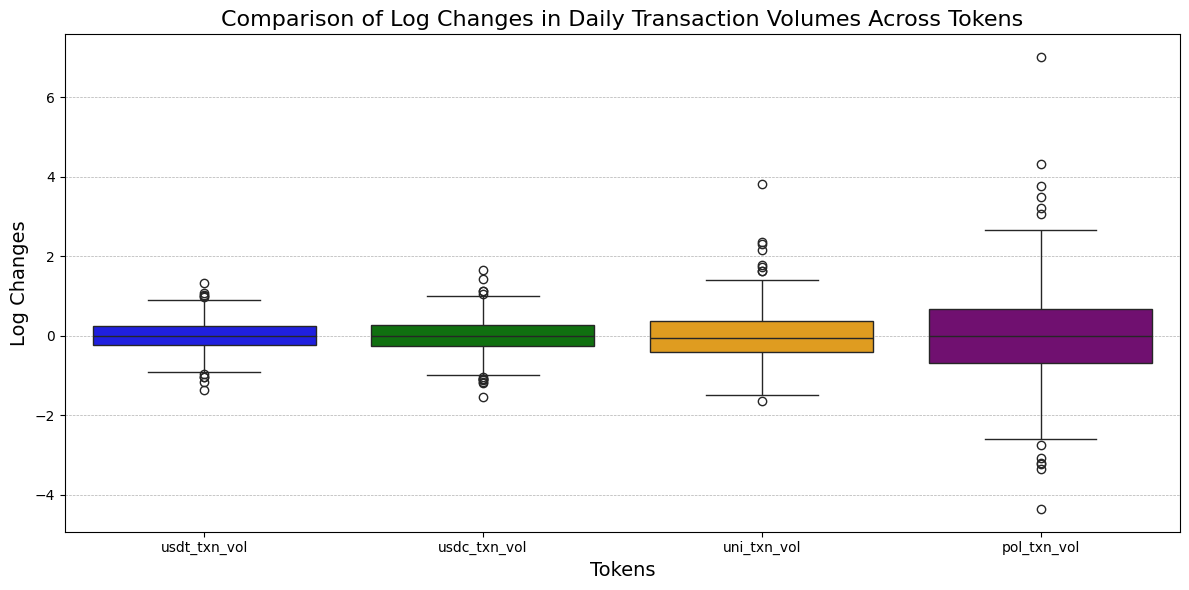

In [297]:
create_boxplot_comparison(volume_changes_df, token_colors)

### 3.5 Testing Normality of Daily Transaction Volume Changes

In [298]:
def analyze_distribution_changes(volume_changes_df):
    """
    Analyzes the distribution of log changes and checks normality.

    Args:
        volume_changes_df (pd.DataFrame): DataFrame containing log changes for tokens.
    """
    # Select only the log-change columns (excluding outlier flags)
    log_change_columns = [col for col in volume_changes_df.columns if not col.endswith("_outlier") and col != "is_outlier"]

    # Dynamically adjust the number of subplots
    num_tokens = len(log_change_columns)
    rows = (num_tokens + 1) // 2  # Calculate rows needed for 2 columns
    fig, axes = plt.subplots(rows, 2, figsize=(12, 4 * rows), sharex=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    # Assign unique colors for each token
    colors = ['blue', 'green', 'orange', 'purple', 'red', 'cyan']

    # Loop through selected log-change columns
    for idx, token in enumerate(log_change_columns):
        changes = volume_changes_df[token]
        sns.histplot(changes, kde=True, ax=axes[idx], bins=50, color=colors[idx % len(colors)])
        axes[idx].set_title(f"Histogram of Log Changes for {token}")
        axes[idx].set_xlabel("Log Changes")
        axes[idx].set_ylabel("Frequency")
        
        # Perform normality tests
        shapiro_stat, shapiro_p = shapiro(changes)
        ks_stat, ks_p = kstest(changes, 'norm')

        print(f"{token} - Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
        print(f"{token} - Kolmogorov-Smirnov Test: Statistic={ks_stat:.4f}, p-value={ks_p:.4f}")
        print("Note: p-value < 0.05 suggests the data is not normally distributed.\n")

    # Hide unused subplots
    for ax in axes[len(log_change_columns):]:
        ax.axis("off")

    plt.tight_layout()
    output_path = os.path.join(output_dir, "histograms_txn_vol_changes_all_tokens.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()


usdt_txn_vol - Shapiro-Wilk Test: Statistic=0.9956, p-value=0.3875
usdt_txn_vol - Kolmogorov-Smirnov Test: Statistic=0.2144, p-value=0.0000
Note: p-value < 0.05 suggests the data is not normally distributed.

usdc_txn_vol - Shapiro-Wilk Test: Statistic=0.9921, p-value=0.0488
usdc_txn_vol - Kolmogorov-Smirnov Test: Statistic=0.1842, p-value=0.0000
Note: p-value < 0.05 suggests the data is not normally distributed.

uni_txn_vol - Shapiro-Wilk Test: Statistic=0.9595, p-value=0.0000
uni_txn_vol - Kolmogorov-Smirnov Test: Statistic=0.1258, p-value=0.0000
Note: p-value < 0.05 suggests the data is not normally distributed.

pol_txn_vol - Shapiro-Wilk Test: Statistic=0.9707, p-value=0.0000
pol_txn_vol - Kolmogorov-Smirnov Test: Statistic=0.0468, p-value=0.3880
Note: p-value < 0.05 suggests the data is not normally distributed.



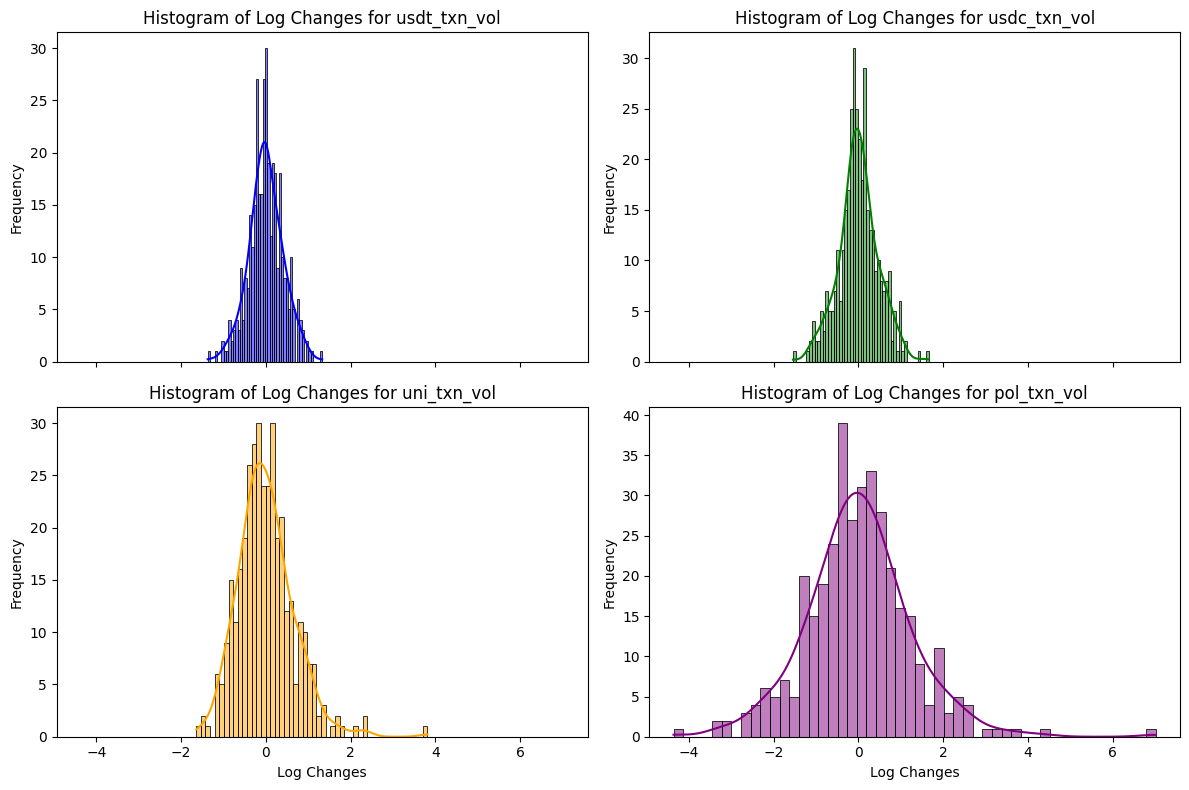

In [308]:
analyze_distribution_changes(volume_changes_df)


#### Conclusion
- For USDC, UNI, and POL, the data is not normally distributed based on Shapiro-Wilk and Kolmogorov-Smirnov results.
- For USDT, the conflicting results lean toward treating it as non-normal given the Kolmogorov-Smirnov outcome.

### 3.6 Analyzing Significant Volume Changes Using IQR

#### Justification of Using IQR:
IQR was chosen because it aligns well with the skewed nature of the data and provides a simple yet effective method to flag significant changes.

- Pros:
  - Robust to skewed distributions and extreme values.
  - Simple to implement.
  - Effectively identifies significant anomalies.
- Cons:
  - Ignores temporal trends or seasonality.
  - May miss context or confuse random noise with meaningful anomalies.

In [300]:
def detect_outliers_iqr(df, column):
    """
    Detect outliers in a DataFrame column using the IQR method.

    Args:
        df (pd.DataFrame): DataFrame containing the column to analyze.
        column (str): Column name to perform IQR-based outlier detection.

    Returns:
        pd.Series: Boolean Series indicating outliers for the column.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers for this column
    is_outlier = (df[column] < lower_bound) | (df[column] > upper_bound)

    print(f"{column} - Found {is_outlier.sum()} outliers using IQR.")
    print(f"Lower Bound: {lower_bound:.4f}, Upper Bound: {upper_bound:.4f}")
    return is_outlier


#### Detect outliers for each token and consolidate into a single column


In [301]:
outlier_flags = {}

for token in ["usdt_txn_vol", "usdc_txn_vol", "uni_txn_vol", "pol_txn_vol"]:
    outlier_flags[token] = detect_outliers_iqr(volume_changes_df, token)

# Add individual outlier flags to the DataFrame
for token, flag in outlier_flags.items():
    volume_changes_df[f"{token}_outlier"] = flag

# Consolidate all token outliers into a single 'is_outlier' column
volume_changes_df["is_outlier"] = volume_changes_df[
    [f"{token}_outlier" for token in ["usdt_txn_vol", "usdc_txn_vol", "uni_txn_vol", "pol_txn_vol"]]
].any(axis=1)

print(f"Total Outliers Across All Tokens: {volume_changes_df['is_outlier'].sum()}")


usdt_txn_vol - Found 10 outliers using IQR.
Lower Bound: -0.9497, Upper Bound: 0.9615
usdc_txn_vol - Found 13 outliers using IQR.
Lower Bound: -1.0287, Upper Bound: 1.0327
uni_txn_vol - Found 9 outliers using IQR.
Lower Bound: -1.5836, Upper Bound: 1.5349
pol_txn_vol - Found 12 outliers using IQR.
Lower Bound: -2.7128, Upper Bound: 2.7010
Total Outliers Across All Tokens: 37


### 3.7 Visualization of Outliers

In [302]:
def plot_time_series_with_outliers(volume_changes_df):
    """
    Plot time series of daily transaction volume changes with individual flagged outliers.

    Args:
        volume_changes_df (pd.DataFrame): DataFrame of daily transaction volume changes,
                                          including individual outlier columns for each token.
    """
    # Filter only the token columns (no "_outlier" or unrelated columns)
    tokens = [col for col in volume_changes_df.columns if col.endswith("_txn_vol")]
    outlier_columns = [f"{token}_outlier" for token in tokens]

    num_tokens = len(tokens)  # Number of tokens to plot
    colors = ['blue', 'green', 'orange', 'purple']  # Unique colors for each token

    # Dynamically handle subplots
    fig, axes = plt.subplots(num_tokens, 1, figsize=(12, 5 * num_tokens), sharex=True)

    # Handle single token case (axes is not an array)
    if num_tokens == 1:
        axes = [axes]

    for idx, (token, outlier_col) in enumerate(zip(tokens, outlier_columns)):
        if outlier_col not in volume_changes_df.columns:
            continue  # Skip if the outlier column doesn't exist

        ax = axes[idx]

        # Plot time series
        ax.plot(volume_changes_df.index, volume_changes_df[token], label=f"{token} Changes", alpha=0.7, color=colors[idx % len(colors)])
        ax.scatter(
            volume_changes_df.index[volume_changes_df[outlier_col]],  # Index of outliers
            volume_changes_df[token][volume_changes_df[outlier_col]],  # Outlier values
            color="red", label="Outliers", zorder=5
        )
        ax.set_title(f"{token} Volume Changes with Outliers")
        ax.set_ylabel("Log Change")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.legend()

    plt.tight_layout()
    output_path = os.path.join(output_dir, "outliers_txn_vol_changes_all_tokens.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.show()

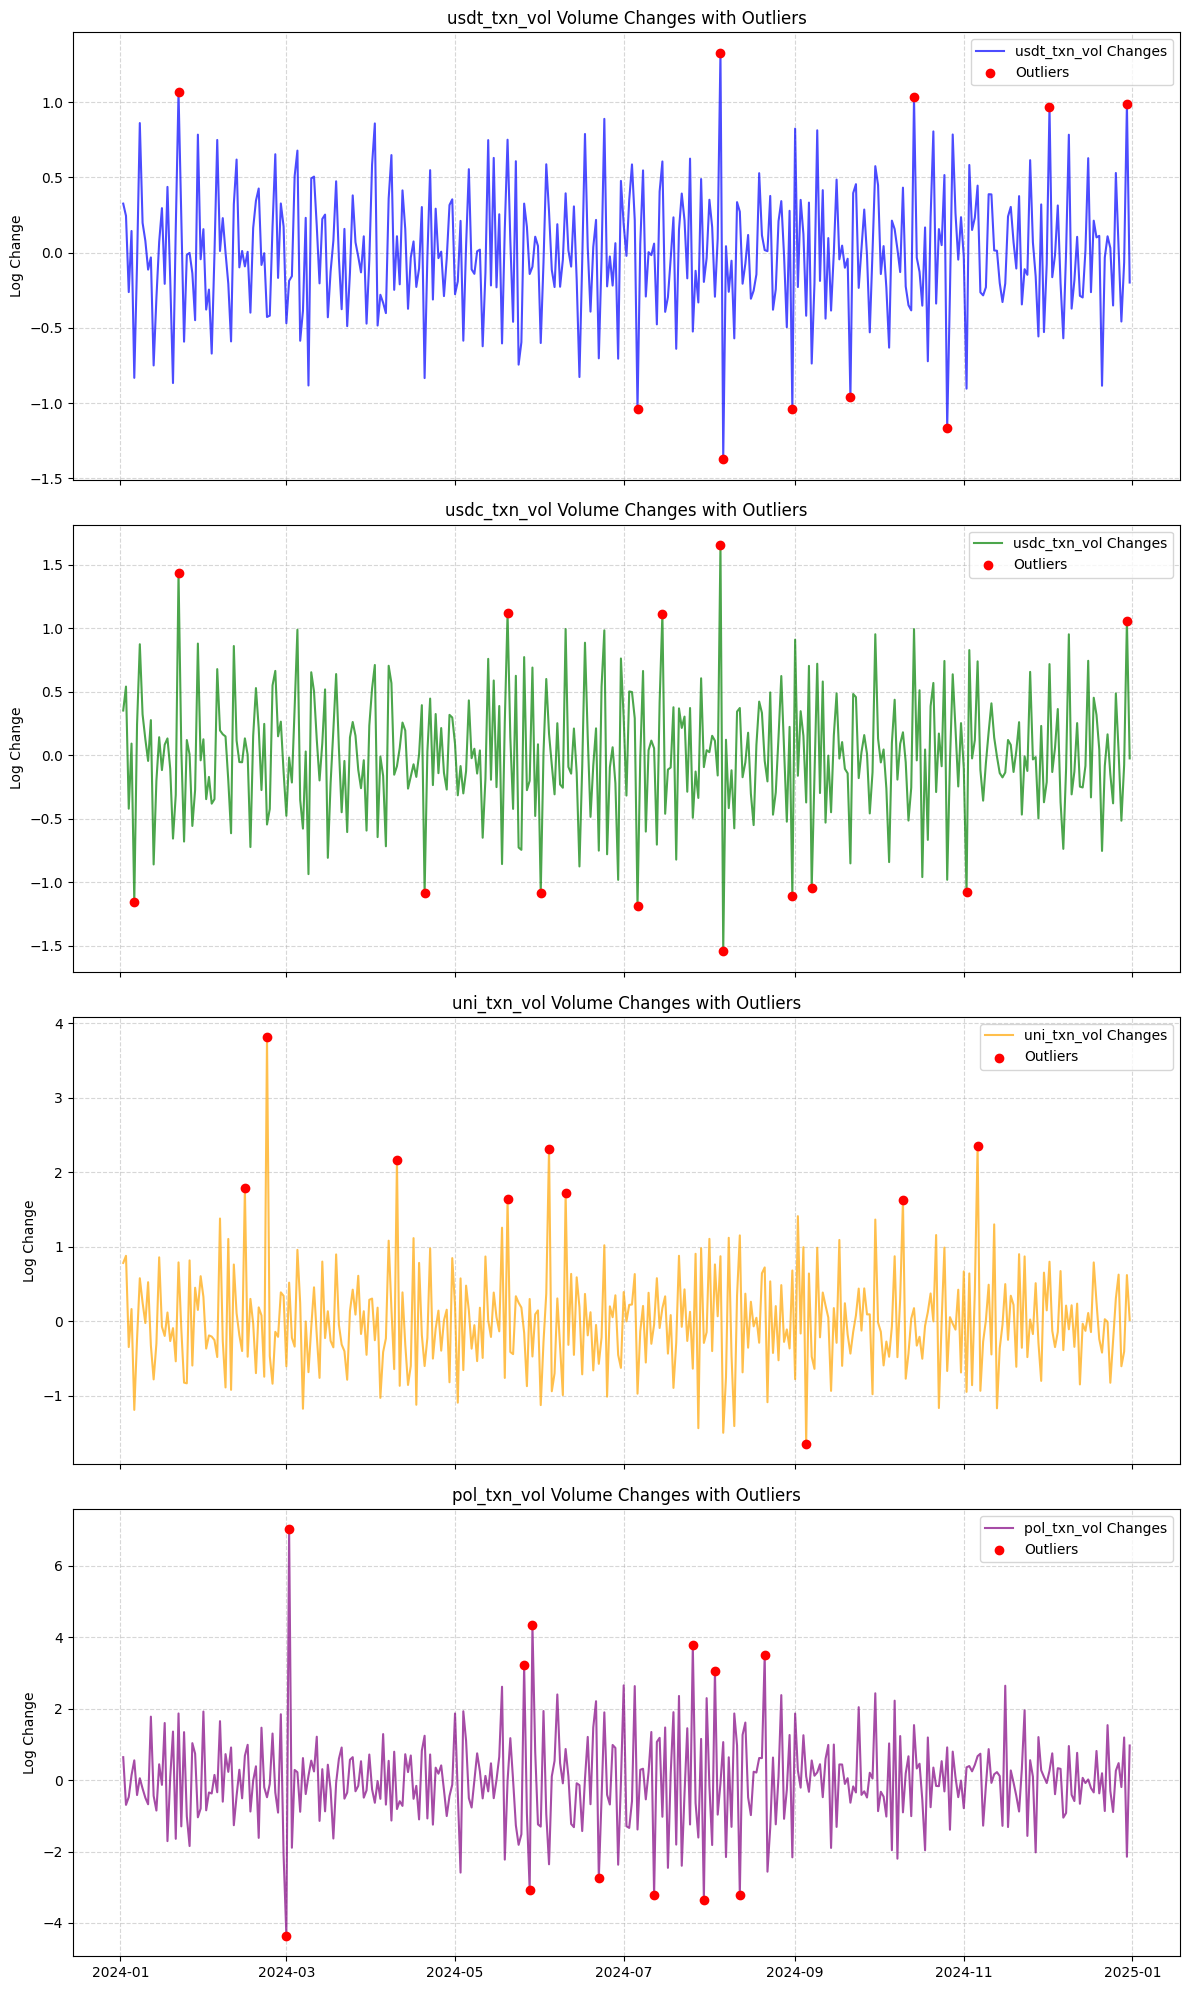

In [303]:
plot_time_series_with_outliers(volume_changes_df)

# 4. Correlation Analysis (With External Data) 

### 4.1 Load External Data (BTC & ETH price, Ethereum gas fee)

In [106]:
ethereum_gas_fee_df = pd.read_csv("data/on-chain/eth_gas_fees_2024.csv", parse_dates=["day"], index_col="day")
btc_df = pd.read_csv("data/off-chain/btc_prices.csv", parse_dates=["Date"], index_col="Date")
eth_df = pd.read_csv("data/off-chain/eth_prices.csv", parse_dates=["Date"], index_col="Date")

# Calculate log changes
ethereum_gas_fee_df['log_change_gas_fee'] = ethereum_gas_fee_df['total_gas_fee_eth'].pct_change().apply(lambda x: np.log1p(x))
btc_df['btc_log_change'] = btc_df['price'].pct_change().apply(lambda x: np.log1p(x))
eth_df['eth_log_change'] = eth_df['price'].pct_change().apply(lambda x: np.log1p(x))

# Remove non-relevant columns
ethereum_gas_fee_df = ethereum_gas_fee_df.drop(['total_gas_fee_eth', "transaction_count"], axis=1)
btc_df = btc_df.drop(['price'], axis=1)
eth_df = eth_df.drop(['price'], axis=1)

# Overview of external datasets
datasets_external = {"Ethereum Gas Fee": ethereum_gas_fee_df, "BTC": btc_df, "ETH": eth_df}
for data, df in datasets_external.items():
    print(f"{data} DataFrame:")
    print(df.info(), "\n")

Ethereum Gas Fee DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   log_change_gas_fee  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None 

BTC DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   btc_log_change  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None 

ETH DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eth_log_change  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None 



In [149]:
# External metrics combined
external_data_log_changes = pd.concat([
    btc_df[['btc_log_change']],
    eth_df[['eth_log_change']],
    ethereum_gas_fee_df[['log_change_gas_fee']]
], axis=1).dropna()
external_data_log_changes.head()

,btc_log_change,eth_log_change,log_change_gas_fee
2024-01-02,0.017743,0.001490,0.408576
2024-01-03,-0.048065,-0.063559,0.581857
2024-01-04,0.030607,0.026019,-0.415200
2024-01-05,-0.000390,-0.000172,-0.155638
2024-01-06,-0.003936,-0.011983,-0.131446


### 4.2 Consolidate Outlier Clusters

In [195]:
def consolidate_clusters(clusters, buffer_days=0):
    """
    Consolidate overlapping or close clusters into non-overlapping periods.

    Args:
        clusters (list): List of date ranges (pd.DatetimeIndex).
        buffer_days (int): Number of days to allow as a gap for merging clusters.

    Returns:
        list: Consolidated list of date ranges.
    """
    if not clusters:
        return []

    # Sort clusters by start date
    sorted_clusters = sorted(clusters, key=lambda x: x[0])
    consolidated = [sorted_clusters[0]]

    for cluster in sorted_clusters[1:]:
        last_cluster = consolidated[-1]

        # Check if clusters overlap or are within the buffer
        if cluster[0] <= last_cluster[-1] + pd.Timedelta(days=buffer_days):
            # Merge clusters
            new_cluster = pd.date_range(start=last_cluster[0], end=max(last_cluster[-1], cluster[-1]))
            consolidated[-1] = new_cluster
        else:
            consolidated.append(cluster)

    return consolidated


consolidated_token_clusters = {}
buffer_days = 1

for token, clusters in token_outlier_clusters.items():
    consolidated_token_clusters[token] = consolidate_clusters(clusters, buffer_days=buffer_days)

for token, clusters in consolidated_token_clusters.items():
    print(f"{token} - Consolidated Outlier Clusters:")
    for cluster in clusters:
        print(f"{cluster[0]} to {cluster[-1]}")


usdt_txn_vol - Consolidated Outlier Clusters:
2024-01-19 00:00:00 to 2024-01-25 00:00:00
2024-07-03 00:00:00 to 2024-07-09 00:00:00
2024-08-02 00:00:00 to 2024-08-09 00:00:00
2024-08-28 00:00:00 to 2024-09-03 00:00:00
2024-09-18 00:00:00 to 2024-09-24 00:00:00
2024-10-11 00:00:00 to 2024-10-17 00:00:00
2024-10-23 00:00:00 to 2024-10-29 00:00:00
2024-11-29 00:00:00 to 2024-12-05 00:00:00
2024-12-27 00:00:00 to 2025-01-02 00:00:00
usdc_txn_vol - Consolidated Outlier Clusters:
2024-01-03 00:00:00 to 2024-01-09 00:00:00
2024-01-19 00:00:00 to 2024-01-25 00:00:00
2024-04-17 00:00:00 to 2024-04-23 00:00:00
2024-05-17 00:00:00 to 2024-05-23 00:00:00
2024-05-29 00:00:00 to 2024-06-04 00:00:00
2024-07-03 00:00:00 to 2024-07-09 00:00:00
2024-07-12 00:00:00 to 2024-07-18 00:00:00
2024-08-02 00:00:00 to 2024-08-09 00:00:00
2024-08-28 00:00:00 to 2024-09-10 00:00:00
2024-10-30 00:00:00 to 2024-11-05 00:00:00
2024-12-27 00:00:00 to 2025-01-02 00:00:00
uni_txn_vol - Consolidated Outlier Clusters:
202

### 4.3 Combine Datasets

In [219]:
def prepare_combined_df(volume_changes_df, external_data):
    """
    Combine token volume changes and external metrics into a single DataFrame.
    
    Args:
        volume_changes_df (pd.DataFrame): DataFrame containing token volume changes.
        external_data (pd.DataFrame): DataFrame containing external metrics (BTC, ETH, gas fees).
    
    Returns:
        pd.DataFrame: Combined DataFrame for rolling correlation analysis.
    """
    # Drop unnecessary columns
    volume_changes_df = volume_changes_df[[
        "usdt_txn_vol", "usdc_txn_vol", "uni_txn_vol", "pol_txn_vol",
        "usdt_txn_vol_outlier", "usdc_txn_vol_outlier", "uni_txn_vol_outlier", "pol_txn_vol_outlier"
    ]]
    
    # Combine with external metrics
    combined_df = pd.concat([volume_changes_df, external_data], axis=1)
    return combined_df

combined_df = prepare_combined_df(volume_changes_df, external_data_log_changes)
combined_df.head()

,usdt_txn_vol,usdc_txn_vol,uni_txn_vol,pol_txn_vol,usdt_txn_vol_outlier,usdc_txn_vol_outlier,uni_txn_vol_outlier,pol_txn_vol_outlier,btc_log_change,eth_log_change,log_change_gas_fee
2024-01-02,0.326112,0.351271,0.781779,0.641689,False,False,False,False,0.017743,0.001490,0.408576
2024-01-03,0.244794,0.539900,0.877036,-0.693766,False,False,False,False,-0.048065,-0.063559,0.581857
2024-01-04,-0.261733,-0.421566,-0.347348,-0.474117,False,False,False,False,0.030607,0.026019,-0.415200
2024-01-05,0.144409,0.091063,0.162843,0.137438,False,False,False,False,-0.000390,-0.000172,-0.155638
2024-01-06,-0.831690,-1.156474,-1.190543,0.552981,False,True,False,False,-0.003936,-0.011983,-0.131446


### 4.4 Rolling Correlation Analysis

In [228]:
def compute_rolling_correlations(combined_df, window=7):
    """
    Compute rolling correlations for token volumes against external metrics.
    
    Args:
        combined_df (pd.DataFrame): Combined DataFrame with token volumes and external metrics.
        window (int): Size of the rolling window.
    
    Returns:
        pd.DataFrame: Rolling correlations with multi-level columns.
    """
    tokens = ["usdt_txn_vol", "usdc_txn_vol", "uni_txn_vol", "pol_txn_vol"]
    external_metrics = ["btc_log_change", "eth_log_change", "log_change_gas_fee"]
    
    # Initialize a dictionary to store correlations
    rolling_corr_dict = {}
    for token in tokens:
        for metric in external_metrics:
            rolling_corr_dict[(token, metric)] = (
                combined_df[token].rolling(window=window).corr(combined_df[metric])
            )
    
    # Convert the dictionary to a DataFrame with multi-level columns
    rolling_corr = pd.DataFrame(rolling_corr_dict)
    return rolling_corr

# Compute rolling correlations
rolling_corr = compute_rolling_correlations(combined_df, window=14)


In [312]:
def plot_rolling_correlations(rolling_corr, token_clusters, combined_df, output_dir):
    """
    Plot rolling correlations for each token with outlier clusters annotated and save as separate images.
    
    Args:
        rolling_corr (pd.DataFrame): Rolling correlations with multi-level columns.
        token_clusters (dict): Consolidated clusters of outlier periods per token.
        combined_df (pd.DataFrame): Combined DataFrame with token volumes and external metrics.
        output_dir (str): Directory to save the generated plots.
    """

    for token in ["usdt_txn_vol", "usdc_txn_vol", "uni_txn_vol", "pol_txn_vol"]:
        plt.figure(figsize=(12, 6))
        
        # Plot rolling correlations for each external metric
        for external_metric in ["btc_log_change", "eth_log_change", "log_change_gas_fee"]:
            plt.plot(
                rolling_corr[(token, external_metric)],
                label=f"Corr with {external_metric}",
                alpha=0.7
            )

        # Annotate outlier clusters
        if token in token_clusters:
            for cluster in token_clusters[token]:
                # Extract the start and end dates from each cluster
                window_start = cluster.min()
                window_end = cluster.max()
                plt.axvspan(window_start, window_end, color='red', alpha=0.2, label=None)

        plt.title(f"Rolling Correlations for {token} (7-day Window)")
        plt.xlabel("Date")
        plt.ylabel("Correlation")
        plt.legend(loc="upper left", labels=["BTC Correlation", "ETH Correlation", "Gas Fee Correlation", "Outlier Cluster"])
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        
        output_path = os.path.join(output_dir, f"rolling_correlation_{token}.png")
        plt.savefig(output_path, dpi=300, bbox_inches="tight")


Saved plot for usdt_txn_vol to ./img/rolling_correlation_usdt_txn_vol.png
Saved plot for usdc_txn_vol to ./img/rolling_correlation_usdc_txn_vol.png
Saved plot for uni_txn_vol to ./img/rolling_correlation_uni_txn_vol.png
Saved plot for pol_txn_vol to ./img/rolling_correlation_pol_txn_vol.png


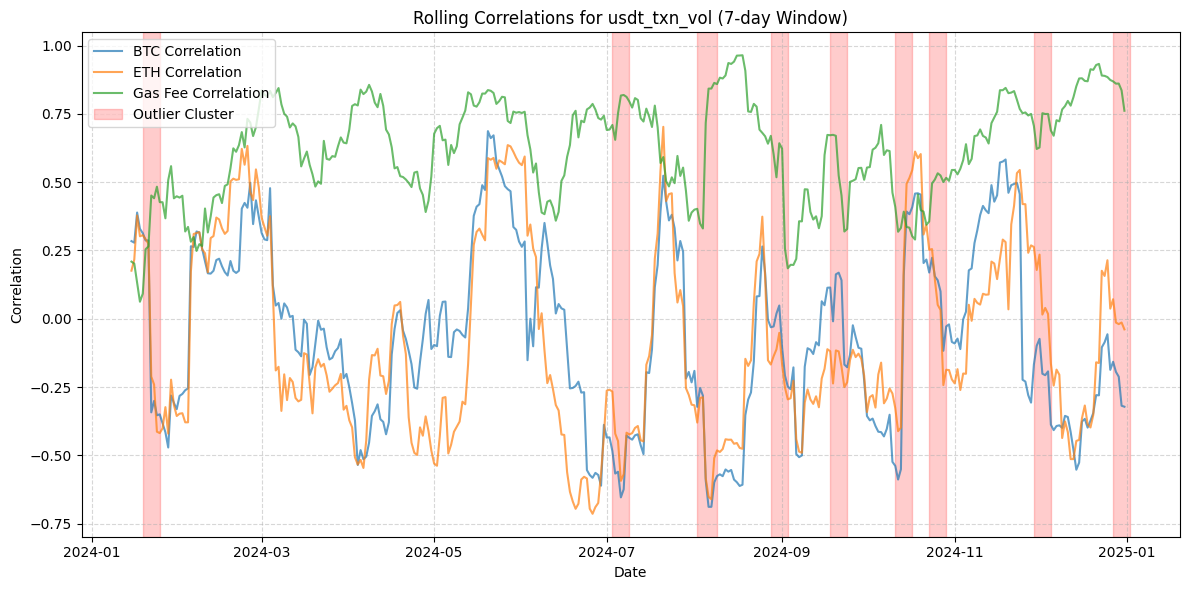

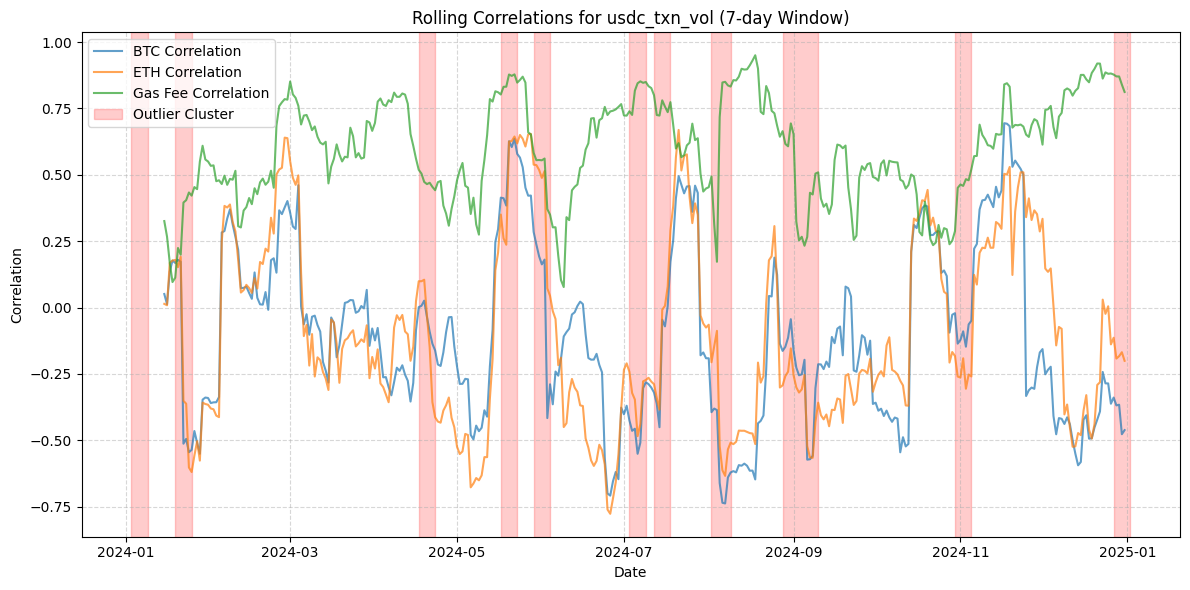

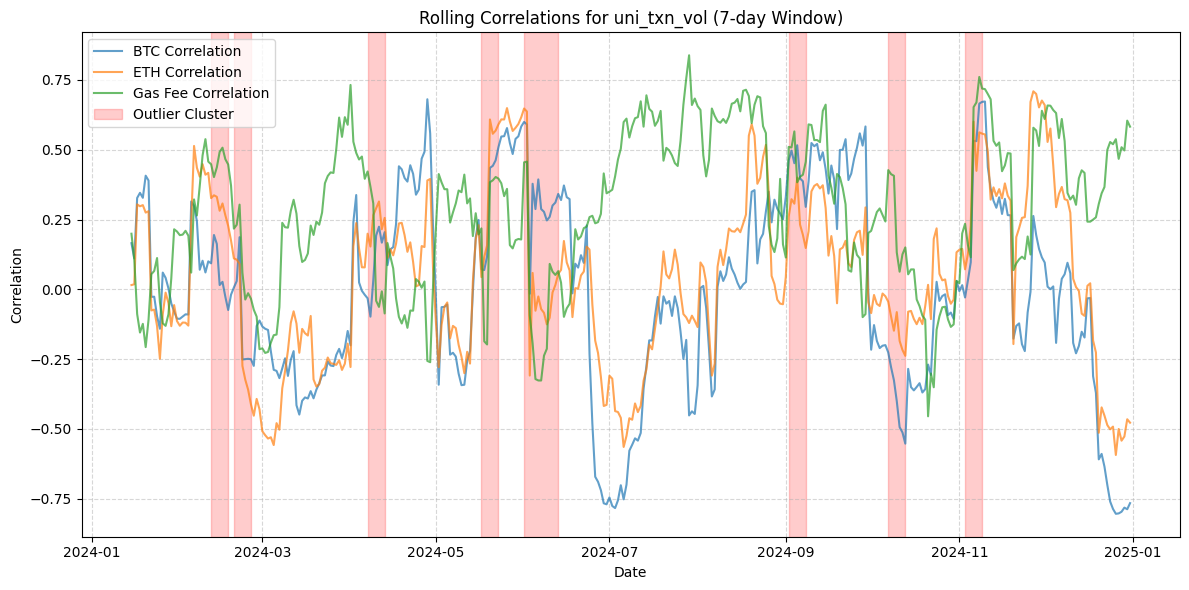

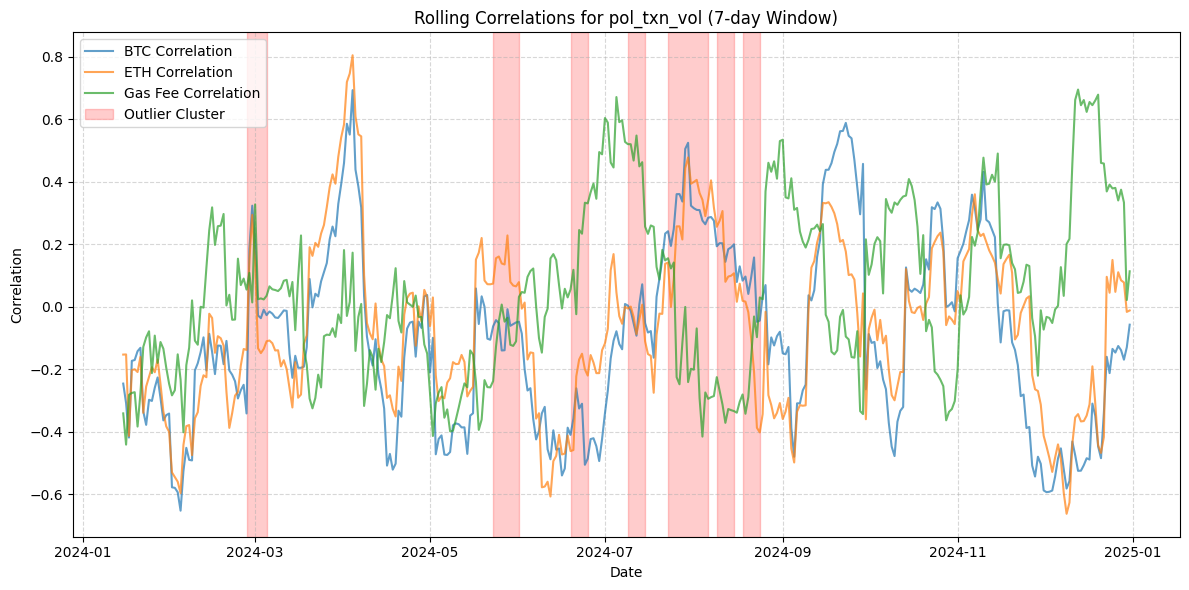

In [311]:
plot_rolling_correlations(rolling_corr, consolidated_token_clusters, combined_df, output_dir)


In [232]:
#stablecoin & protocol token analysis:

In [236]:
volume_changes_df[(volume_changes_df['usdt_txn_vol_outlier'] == True) & 
                  (volume_changes_df['usdc_txn_vol_outlier'] == True)]


,usdt_txn_vol,usdc_txn_vol,uni_txn_vol,pol_txn_vol,is_outlier,usdt_txn_vol_outlier,usdc_txn_vol_outlier,uni_txn_vol_outlier,pol_txn_vol_outlier,context_outlier_flag
day,,,,,,,,,,
2024-01-22,1.066032,1.430439,0.788897,1.865930,True,True,True,False,False,True
2024-07-06,-1.040390,-1.184496,-0.973089,-1.383952,True,True,True,False,False,True
2024-08-05,1.329313,1.655127,0.871427,-0.091902,True,True,True,False,False,True
2024-08-06,-1.372686,-1.545530,-1.497765,1.064193,True,True,True,False,False,True
2024-08-31,-1.037621,-1.110180,0.680514,-2.162476,True,True,True,False,False,True
2024-12-30,0.988253,1.058197,0.618542,-2.145944,True,True,True,False,False,True
